# Pycaret

In [1]:
!pip install -U pandas-profiling
!pip install pycaret
!pip install markupsafe==2.0.1
!pip install optuna
!pip install catboost
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.1.1-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (25 kB)
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached MarkupSafe-2.0.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl (31 kB)
  Attempting uninstall: markupsaf

In [2]:
import os
import random
import numpy as np
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from pycaret.regression import *

import re
import warnings
warnings.filterwarnings('ignore')

import argparse
import wandb
wandb.init(project="DACON_235901", name="pycaret")

parser = argparse.ArgumentParser(description="pycaret")
parser.add_argument('--ensemble', default="blending", type=str) # blending or stacking
parser.add_argument('--best_n', default=16, type=int)
parser.add_argument('--scaler', default="standard", type=str) # standard or minmax
parser.add_argument('--tune_iter', default=50, type=int)
parser.add_argument('--cv', default=10, type=int)
parser.add_argument('--seed', default=1011, type=int)
args = parser.parse_args('')

wandb.config.update(args)

ensemble = args.ensemble
best_n = args.best_n
scaler = args.scaler
tune_iter = args.tune_iter
cv = args.cv
seed = args.seed

if scaler == "standard":
    scaler=StandardScaler()
elif scaler == "minmax":
    scaler=MinMaxScaler()

def set_seeds(seed=seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_seeds()

train = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/data/train.csv")
test = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/data/test.csv")

train.head()

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
wandb: Currently logged in as: gnoeyheat. Use `wandb login --relogin` to force relogin


,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,13665000
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,33015000
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,9915000
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,3815000
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,7385000


### Pandas Profiling

In [3]:
pr = train.profile_report()
pr

Output hidden; open in https://colab.research.google.com to view.

## Preprocessing

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1015 entries, 0 to 1014
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1015 non-null   int64 
 1   title         1015 non-null   object
 2   odometer      1015 non-null   int64 
 3   location      1015 non-null   object
 4   isimported    1015 non-null   object
 5   engine        1015 non-null   object
 6   transmission  1015 non-null   object
 7   fuel          1015 non-null   object
 8   paint         1015 non-null   object
 9   year          1015 non-null   int64 
 10  target        1015 non-null   int64 
dtypes: int64(4), object(7)
memory usage: 87.4+ KB


In [5]:
train.describe()

,id,odometer,year,target
count,1015.000000,1015.000000,1015.000000,1.015000e+03
mean,507.000000,116842.121182,2008.385222,8.243204e+06
std,293.149564,105162.545836,35.592123,1.239567e+07
min,0.000000,0.000000,1217.000000,4.000000e+05
25%,253.500000,55918.000000,2006.000000,2.535000e+06
50%,507.000000,94972.000000,2010.000000,4.215000e+06
75%,760.500000,153224.000000,2014.000000,8.927500e+06
max,1014.000000,987322.000000,2020.000000,1.500150e+08


In [6]:
train.describe(include="object")

,title,location,isimported,engine,transmission,fuel,paint
count,1015,1015,1015,1015,1015,1015,1015
unique,203,13,3,8,2,2,76
top,Toyota Camry,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Black
freq,129,792,744,618,965,970,292


### target

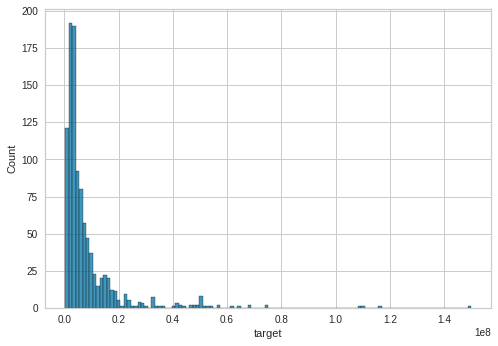

In [7]:
sns.histplot(train["target"])
plt.show()

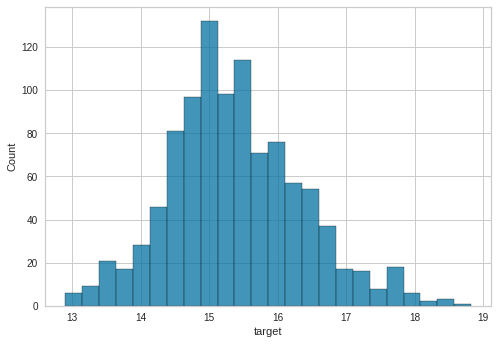

In [8]:
train["target"] = np.log(train["target"])
sns.histplot(train["target"])
plt.show()

### odometer

In [9]:
odometer_median = train["odometer"].median()

train["odometer"] = train["odometer"].replace(0, odometer_median)
test["odometer"] = test["odometer"].replace(0, odometer_median)

train["odometer"].min(), test["odometer"].min()

(10, 38)

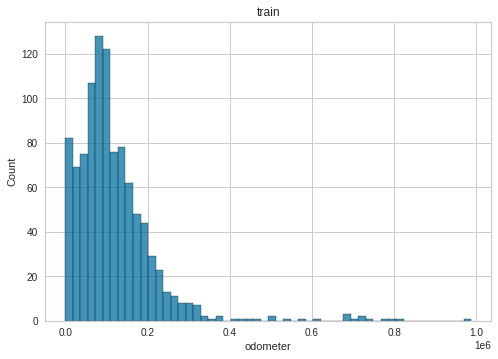

In [10]:
sns.histplot(train["odometer"])
plt.title("train")
plt.show()

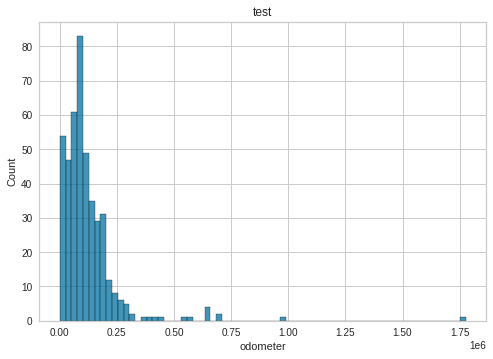

In [11]:
sns.histplot(test["odometer"])
plt.title("test")
plt.show()

### year

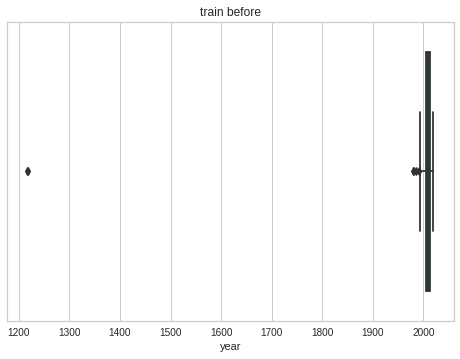

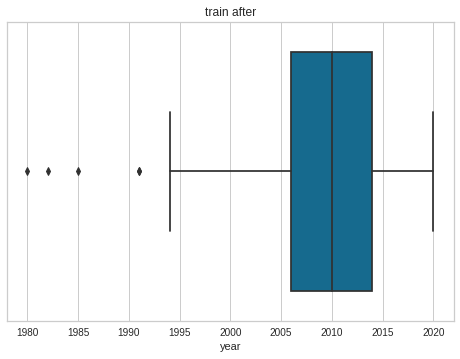

In [12]:
sns.boxplot(x="year", data=train)
plt.title("train before")
plt.show()

train = train[train["year"]>1900]

sns.boxplot(x="year", data=train)
plt.title("train after")
plt.show()

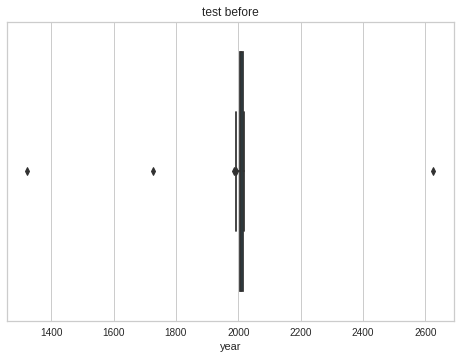

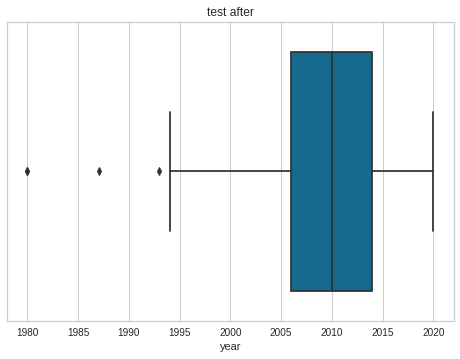

In [13]:
sns.boxplot(x="year", data=test)
plt.title("test before")
plt.show()

test["year"] = test["year"].apply(lambda x : train["year"].min() if x<1900 else x)
test["year"] = test["year"].apply(lambda x : train["year"].max() if x>2022 else x)

sns.boxplot(x="year", data=test)
plt.title("test after")
plt.show()

### title

In [14]:
def title(df):
    df["brand"] = df["title"].apply(lambda x : x.split(" ")[0])
    return df

In [15]:
train = title(train)
test = title(test)

train.head()

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,brand
0,0,Toyota RAV 4,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,16.430348,Toyota
1,1,Toyota Land Cruiser,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,17.312473,Toyota
2,2,Land Rover Range Rover Evoque,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,16.109559,Land
3,3,Lexus ES 350,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,15.154451,Lexus
4,4,Toyota Venza,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,15.814961,Toyota


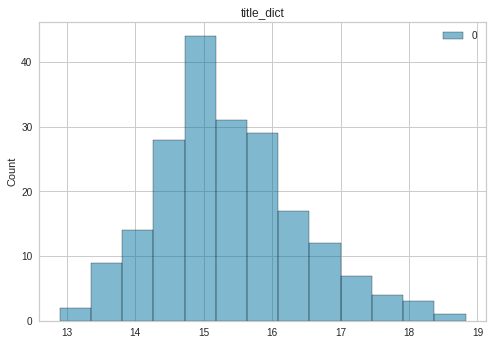

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,brand
0,0,15.553550,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,16.430348,Toyota
1,1,17.312851,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,17.312473,Toyota
2,2,16.913673,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,16.109559,Land
3,3,15.262898,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,15.154451,Lexus
4,4,15.751368,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,15.814961,Toyota


In [16]:
title_dict = dict(train.groupby(by="title").median()["target"])

sns.histplot(title_dict.values())
plt.title("title_dict")
plt.show()

train["title"] = [title_dict[k] for k in train["title"]]

temp=[]
for k in test["title"]:
    if k in title_dict:
        temp.append(title_dict[k])
    else:
        temp.append(np.median(list(title_dict.values())))

test["title"] = temp

train.head()

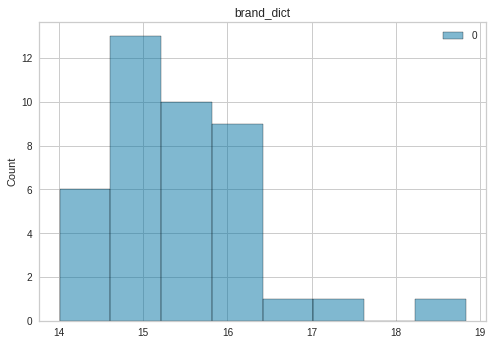

,id,title,odometer,location,isimported,engine,transmission,fuel,paint,year,target,brand
0,0,15.553550,18277,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Red,2016,16.430348,15.195535
1,1,17.312851,10,Lagos,New,4-cylinder(I4),automatic,petrol,Black,2019,17.312473,15.195535
2,2,16.913673,83091,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2012,16.109559,16.994189
3,3,15.262898,91524,Lagos,Foreign Used,4-cylinder(I4),automatic,petrol,Gray,2007,15.154451,15.630630
4,4,15.751368,94177,Lagos,Foreign Used,6-cylinder(V6),automatic,petrol,Red,2010,15.814961,15.195535


In [17]:
brand_dict = dict(train.groupby(by="brand").median()["target"])

sns.histplot(brand_dict.values())
plt.title("brand_dict")
plt.show()

train["brand"] = [brand_dict[k] for k in train["brand"]]

temp=[]
for k in test["brand"]:
    if k in brand_dict:
        temp.append(brand_dict[k])
    else:
        temp.append(np.median(list(brand_dict.values())))

test["brand"] = temp

train.head()

### location

In [18]:
def location(df):
    df["location"] = df["location"].apply(lambda x : x.strip().lower())
    df["location"] = df["location"].apply(lambda x : "lagos" if "lagos" in x else x)
    df["location"] = df["location"].apply(lambda x : "abuja" if ("abuja" and "fct") in x else x)
    df["location"] = df["location"].apply(lambda x : "ogun" if ("ogun" and "ogun state") in x else x)
    df["location"] = df["location"].apply(lambda x : "other" if x not in ["lagos", "abuja", "ogun"] else x)
    return df

In [19]:
train = location(train)
train["location"].value_counts()

lagos    829
abuja    149
ogun      27
other      8
Name: location, dtype: int64

In [20]:
test = location(test)
test["location"].value_counts()

lagos    354
abuja     69
ogun      10
other      3
Name: location, dtype: int64

### isimported

In [21]:
train["isimported"].value_counts()

Foreign Used    744
Locally used    246
New              23
Name: isimported, dtype: int64

In [22]:
test["isimported"].value_counts()

Foreign Used    321
Locally used     97
New              18
Name: isimported, dtype: int64

### engine

In [23]:
def engine(df):
    p1 = re.compile('[(]\D')
    p2 = re.compile('\d*[)]')
    df["engine_1"] = df["engine"].apply(lambda x : p1.search(x)[0][1:])
    df["engine_2"] = df["engine"].apply(lambda x : p2.search(x)[0][:-1]).astype("int")
    df["engine_1"] = df["engine_1"].apply(lambda x : "I" if x == "H" else x)
    return df

In [24]:
train = engine(train)
train["engine_1"].unique(), train["engine_2"].unique()

(array(['I', 'V'], dtype=object), array([4, 6, 8, 5, 3, 2]))

In [25]:
test = engine(test)
test["engine_1"].unique(), test["engine_2"].unique()

(array(['I', 'V'], dtype=object), array([ 4,  6,  8,  5,  2, 12,  3]))

### transmission

In [26]:
train["transmission"].value_counts()

automatic    965
manual        48
Name: transmission, dtype: int64

In [27]:
test["transmission"].value_counts()

automatic    414
manual        22
Name: transmission, dtype: int64

### fuel

In [28]:
train["fuel"].value_counts()

petrol    970
diesel     43
Name: fuel, dtype: int64

In [29]:
test["fuel"].value_counts()

petrol    416
diesel     20
Name: fuel, dtype: int64

### paint

In [30]:
def color(x):
    if (x.find('black') >= 0) or \
    (x.find('blac') >= 0):
        x = "black"
    if (x.find('white') >= 0) or \
    (x.find('cream') >= 0) or \
    (x.find('milk') >= 0):
        x = "white"
    if (x.find('silver') >= 0) or \
    (x.find('sliver') >= 0):
        x = "silver"
    if (x.find('grey') >= 0) or \
    (x.find('gray') >= 0) or \
    (x.find('gery') >= 0) or \
    (x.find('ash') >= 0):
        x = "grey"
    if (x.find('blue') >= 0) or \
    (x.find('purple') >= 0) or \
    (x.find('indigo ink pearl') >= 0):
        x = "blue"
    if (x.find('red') >= 0) or \
    (x.find('wine') >= 0) or \
    (x.find('whine') >= 0) or \
    (x.find('maroon') >= 0) or \
    (x.find('orange') >= 0):
        x = "red"
    if (x.find('gold') >= 0) or \
    (x.find('golf') >= 0) or \
    (x.find('yellow') >= 0):
        x = "gold"
    if x.find('green') >= 0:
        x = "green"
    if (x.find('brown') >= 0) or \
    (x.find('beige') >= 0):
        x = "brown"
    return x

def paint(df):
    df["paint"] = df["paint"].apply(lambda x : x.strip().lower())
    df["paint"] = df["paint"].apply(lambda x : color(x))
    return df

In [31]:
train = paint(train)
train["paint"].value_counts()

black     315
grey      165
white     154
silver    117
blue      106
red        72
gold       45
green      21
brown      18
Name: paint, dtype: int64

In [32]:
test = paint(test)
test["paint"].value_counts()

black     126
silver     67
white      64
grey       64
red        39
blue       38
green      16
gold       15
brown       7
Name: paint, dtype: int64

### Correlation

In [33]:
train = train.drop(["id", "engine"], axis=1)
test = test.drop(["id", "engine"], axis=1)

train.head()

,title,odometer,location,isimported,transmission,fuel,paint,year,target,brand,engine_1,engine_2
0,15.553550,18277,lagos,Foreign Used,automatic,petrol,red,2016,16.430348,15.195535,I,4
1,17.312851,10,lagos,New,automatic,petrol,black,2019,17.312473,15.195535,I,4
2,16.913673,83091,lagos,Foreign Used,automatic,petrol,red,2012,16.109559,16.994189,V,6
3,15.262898,91524,lagos,Foreign Used,automatic,petrol,grey,2007,15.154451,15.630630,I,4
4,15.751368,94177,lagos,Foreign Used,automatic,petrol,red,2010,15.814961,15.195535,V,6


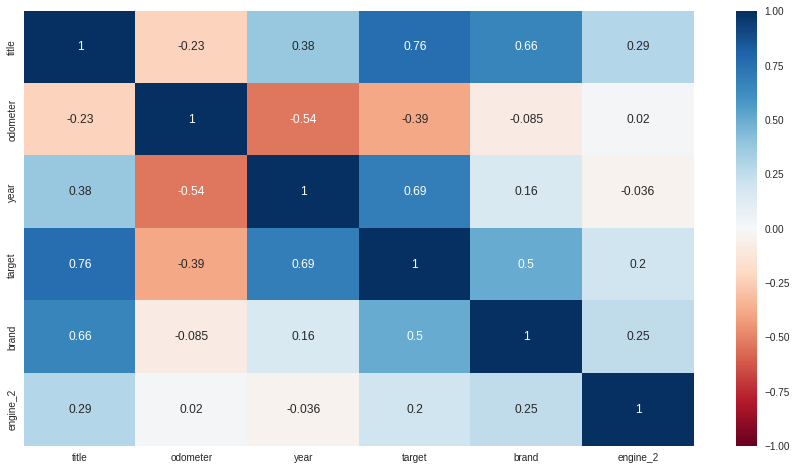

In [34]:
plt.figure(figsize=(15,8))
sns.heatmap(train.corr(), vmin=-1, vmax=1, cmap='RdBu', annot=True)
plt.show()

## Training

### AutoML

In [35]:
s = setup(train, target='target',
          fold_strategy='kfold', fold=cv,
          session_id=seed, log_experiment=True)

,Description,Value
0,session_id,1011
1,Target,target
2,Original Data,"(1013, 12)"
3,Missing Values,False
4,Numeric Features,4
5,Categorical Features,7
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(709, 28)"


In [36]:
def NMAE(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

add_metric('NMAE', 'NMAE', NMAE, greater_is_better=False)

Name                                                       NMAE
Display Name                                               NMAE
Score Function                <function NMAE at 0x7f7494fe1f80>
Scorer               make_scorer(NMAE, greater_is_better=False)
Target                                                     pred
Args                                                         {}
Greater is Better                                         False
Custom                                                     True
Name: NMAE, dtype: object

In [37]:
%%time

if ensemble == 'blending':
    blender = blend_models(compare_models(sort='NMAE', n_select=best_n), choose_better=True)
    tuned_blender = tune_model(blender, n_iter=tune_iter, optimize='NMAE', search_library='optuna', choose_better=True)
    final_model=finalize_model(tuned_blender)

if ensemble == 'stacking':
    stacker = stack_models(compare_models(sort='NMAE', n_select=best_n), choose_better=True)
    tuned_stacker = tune_model(stacker, n_iter=tune_iter, optimize='NMAE', search_library='optuna', choose_better=True)
    final_model=finalize_model(tuned_stacker)

final_model

,MAE,MSE,RMSE,R2,RMSLE,MAPE,NMAE
Fold,,,,,,,
0,0.2396,0.1047,0.3236,0.8916,0.0193,0.0153,0.0155
1,0.1949,0.0690,0.2627,0.9313,0.0166,0.0130,0.0127
2,0.1930,0.0676,0.2600,0.9296,0.0158,0.0125,0.0125
3,0.1744,0.0487,0.2207,0.9262,0.0139,0.0116,0.0114
4,0.2018,0.1008,0.3174,0.9031,0.0195,0.0131,0.0129
5,0.2160,0.0821,0.2866,0.9245,0.0177,0.0143,0.0141
6,0.1966,0.0713,0.2670,0.9236,0.0166,0.0129,0.0128
7,0.2208,0.0839,0.2897,0.9115,0.0179,0.0145,0.0144
8,0.2337,0.1172,0.3424,0.8491,0.0209,0.0152,0.0150


CPU times: user 9min 25s, sys: 39.9 s, total: 10min 5s
Wall time: 7min 8s


In [38]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

## Inference

In [39]:
predictions = predict_model(final_model, data=test)
prediction = predictions['Label']

In [40]:
submission = pd.read_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/data/sample_submission.csv")
submission["target"] = np.exp(prediction).round().astype("int")
submission.to_csv("/content/drive/MyDrive/DACON-Basic/235901_중고차 가격 예측 경진대회/submission.csv", index=False)